In the following, the basic code for making this work is shown and, after that, a set of examples are given.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import constants

sns.set(context="notebook", style="white", palette="colorblind")
%matplotlib inline

from overreact import core, _thermo, simulate

In [2]:
plt.rcParams["figure.dpi"] = 120

## Simple numerical tests

(The example below starts from energy values. Before that, use a reaction scheme for, say, a Michaelis-Menten reaction that has prediction and proposed scheme, against which I can compare results: https://www.beilstein-journals.org/bjoc/articles/6/87)

Now a simple numerical example is due, in the same format as in the other notebook.
I will generate the equations for a Michaelis-Menten like model (same system as in [here](https://en.wikipedia.org/wiki/Petersen_matrix#Example)).

In [3]:
import numpy as np

In [4]:
scheme = core.parse_reactions("""
A + 2 B -> TS* -> S
E + S <=> ES -> ES* -> E + P
""")
scheme.compounds, scheme.reactions, scheme.A, scheme.B

(('A', 'B', 'TS*', 'S', 'E', 'ES', 'ES*', 'P'),
 ('A + 2 B -> TS*',
  'TS* -> S',
  'E + S -> ES',
  'ES -> E + S',
  'ES -> ES*',
  'ES* -> E + P'),
 ((-1.0, 0.0, 0.0, 0.0, 0.0, 0.0),
  (-2.0, 0.0, 0.0, 0.0, 0.0, 0.0),
  (1.0, -1.0, 0.0, 0.0, 0.0, 0.0),
  (0.0, 1.0, -1.0, 1.0, 0.0, 0.0),
  (0.0, 0.0, -1.0, 1.0, 0.0, 1.0),
  (0.0, 0.0, 1.0, -1.0, -1.0, 0.0),
  (0.0, 0.0, 0.0, 0.0, 1.0, -1.0),
  (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)),
 ((-1.0, 0.0, 0.0, 0.0, 0.0, 0.0),
  (-2.0, 0.0, 0.0, 0.0, 0.0, 0.0),
  (1.0, -1.0, 0.0, 0.0, 0.0, 0.0),
  (0.0, 1.0, -1.0, 0.0, 0.0, 0.0),
  (0.0, 0.0, -1.0, 0.0, 0.0, 1.0),
  (0.0, 0.0, 1.0, 0.0, -1.0, 0.0),
  (0.0, 0.0, 0.0, 0.0, 1.0, -1.0),
  (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)))

What we did here is better than in the other notebook, since a matrix $B$ is now available for us to generate $k$:

In [5]:
T = 298.15
kappa = 1.

delta_gibbs = _thermo.get_delta(scheme.B, [0., 1., 10., 5., 1., 1., 7.5, 2.])
K = np.exp(- delta_gibbs / (constants.R * T / constants.kcal))

# This is Eyring's equation
k = kappa * (constants.k * T / constants.h) * K

delta_gibbs, K, k

AttributeError: module 'scipy.constants' has no attribute 'kcal'

Observe that the reaction rates for equilibria satisfy the equilibrium constants.

In [6]:
# TODO: scipy 1.4+ will support passing args from solve_ivp, but for now let's do something rather mundane here
def dydt(t, y):
    A = np.asanyarray(scheme.A)
    r = k * np.prod(np.power(y, np.where(A > 0, 0, -A).T), axis=1)
    return np.dot(scheme.A, r)

array([1.02593073e+00, 5.18614543e-02, 8.16096083e-13, 4.84007503e-07,
       9.97766945e-02, 2.23305439e-04, 1.93127157e-12, 4.73845483e-01])

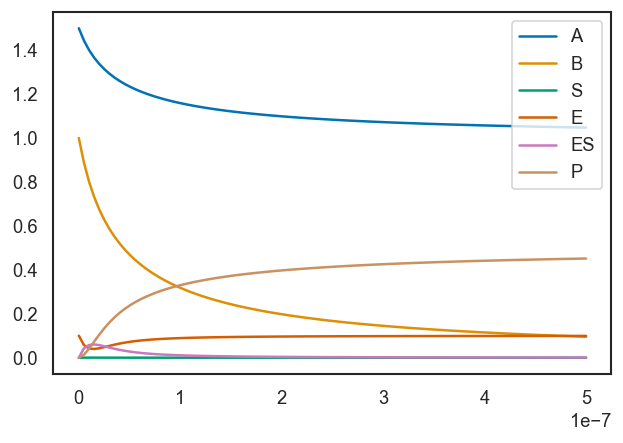

In [7]:
y0 = np.array([1.5, 1., 0., 0., 0.1, 0., 0.0, 0.])
y, r = simulate.get_y(dydt, y0, t_span=[0.0, 1e-6])

t = np.linspace(y.t_min, 5e-7, num=100)
for i, compound in enumerate(scheme.compounds):
    if not compound.endswith("*"):
        plt.plot(t, y(t)[i], label=compound)
plt.legend()
y(y.t_max)